In [2]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
%%capture

!pip install -q kaggle

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c data-science-bowl-2018
print('Dataset downloaded')

!unzip stage1_train.zip -d train_data
print('Train dataset unzipped')

!unzip stage1_test.zip -d test_data
print('Test dataset unzipped')

In [0]:
import os
import cv2
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, concatenate, Dropout

In [0]:
TRAIN_PATH = 'train_data'
TEST_PATH = 'test_data'

IMG_WIDTH = 128 
IMG_HEIGHT = 128

In [0]:
train_ids = os.listdir(TRAIN_PATH)
test_ids = os.listdir(TEST_PATH)

In [0]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.uint8)

In [8]:
for i, id_ in enumerate(train_ids):
  
  image_path = os.path.join(TRAIN_PATH, id_, 'images')
  
  img = cv2.imread(os.path.join(image_path, id_+'.png'))
  img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  X_train[i] = img  
  
  mask_path = os.path.join(TRAIN_PATH, id_, 'masks')
  overlayed_mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  
  for mask_id in os.listdir(mask_path):
    mask = cv2.imread(os.path.join(mask_path, mask_id), 0)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = np.expand_dims(mask, axis=-1)
    overlayed_mask = np.maximum(overlayed_mask, mask)
  
  Y_train[i] = overlayed_mask 

for i, id_ in enumerate(test_ids):
  
  image_path = os.path.join(TEST_PATH, id_, 'images')
  
  img = cv2.imread(os.path.join(image_path, id_+'.png'))
  img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
  img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  
  X_test[i] = img    
  
  
print('Shape of X_train : ', X_train.shape)
print('Shape of Y_train : ', Y_train.shape)
print('Shape of X_test : ', X_test.shape)

Shape of X_train :  (670, 128, 128, 3)
Shape of Y_train :  (670, 128, 128, 1)
Shape of X_test :  (65, 128, 128, 3)


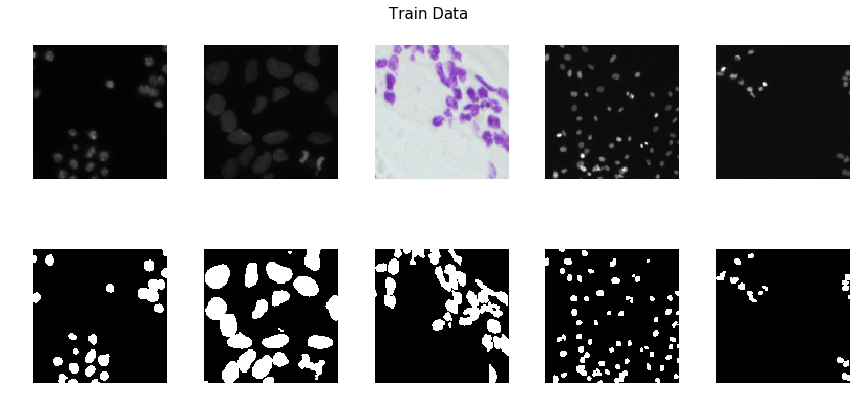

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12,6))

fig.suptitle('Train Data', fontsize=15)

axes = axes.flatten()

for img, ax in zip(X_train[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')

for label, ax in zip(Y_train[:5], axes[5:]):
    ax.imshow(np.squeeze(label), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

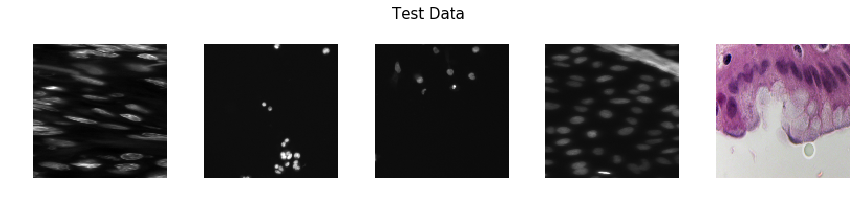

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('Test Data', fontsize=15)

axes = axes.flatten()

for img, ax in zip(X_test[:5], axes[:5]):
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [0]:
X_train = X_train/255
Y_train = Y_train/255
X_test = X_test/255

In [12]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=100, random_state=42)

print('Shape of x_train : ', x_train.shape)
print('Shape of y_train : ', y_train.shape)
print('Shape of x_val : ', x_val.shape)
print('Shape of y_val : ', y_val.shape)

Shape of x_train :  (570, 128, 128, 3)
Shape of y_train :  (570, 128, 128, 1)
Shape of x_val :  (100, 128, 128, 3)
Shape of y_val :  (100, 128, 128, 1)


In [13]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 3))

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (inputs)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        dropout[0][0]                    
______________________________________________________________________________________________

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [63]:
results = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=16, epochs=500, verbose=2)

Train on 570 samples, validate on 100 samples
Epoch 1/500
570/570 - 4s - loss: 0.0043 - val_loss: 0.0040
Epoch 2/500
570/570 - 4s - loss: 0.0043 - val_loss: 0.0040
Epoch 3/500
570/570 - 4s - loss: 0.0043 - val_loss: 0.0041
Epoch 4/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 5/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 6/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0042
Epoch 7/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 8/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 9/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0042
Epoch 10/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0040
Epoch 11/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 12/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0042
Epoch 13/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 14/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0041
Epoch 15/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0040
Epoch 16/500
570/570 - 4s - loss: 0.0042 - val_loss: 0.0040
Epo

In [0]:
pred = model.predict(x_train[:5])

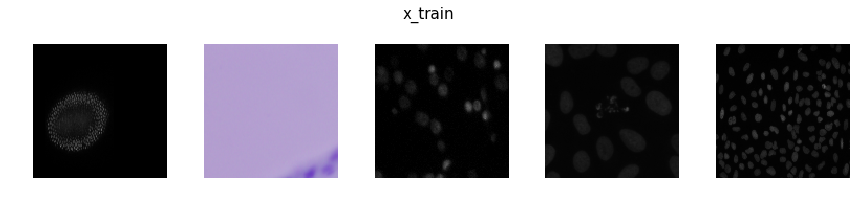

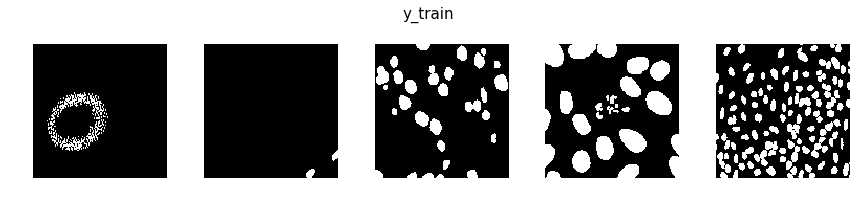

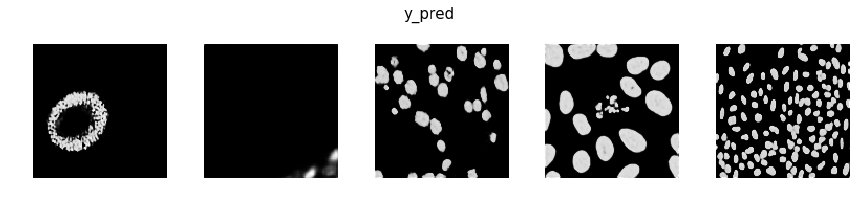

In [65]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('x_train', fontsize=15)

axes = axes.flatten()

for img, ax in zip(x_train[:5], axes):
    ax.imshow(img)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('y_train', fontsize=15)

axes = axes.flatten()

for label, ax in zip(y_train[:5], axes):
    ax.imshow(np.squeeze(label), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('y_pred', fontsize=15)

axes = axes.flatten()

for label, ax in zip(pred[:5], axes):
    ax.imshow(np.squeeze(label), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [0]:
pred = model.predict(x_val[:5])

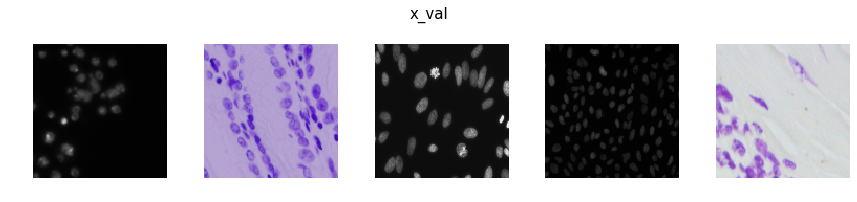

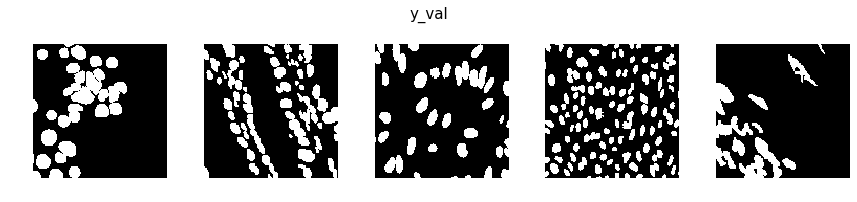

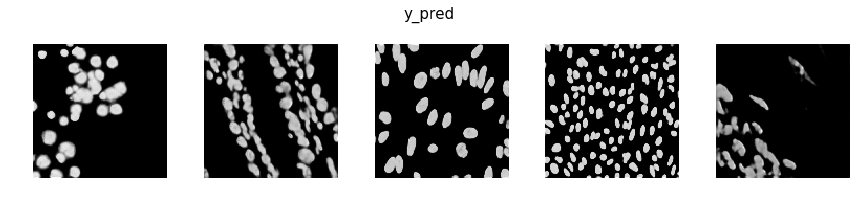

In [67]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('x_val', fontsize=15)

axes = axes.flatten()

for img, ax in zip(x_val[:5], axes):
    ax.imshow(img)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('y_val', fontsize=15)

axes = axes.flatten()

for label, ax in zip(y_val[:5], axes):
    ax.imshow(np.squeeze(label), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('y_pred', fontsize=15)

axes = axes.flatten()

for label, ax in zip(pred[:5], axes):
    ax.imshow(np.squeeze(label), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [0]:
pred = model.predict(X_test[:5])

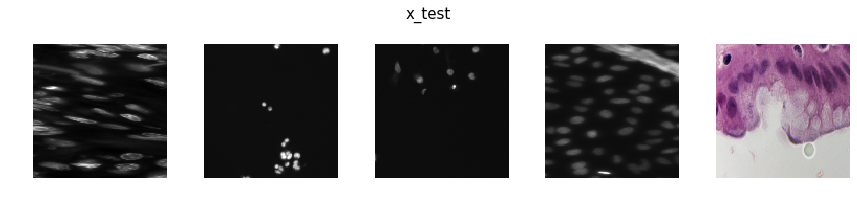

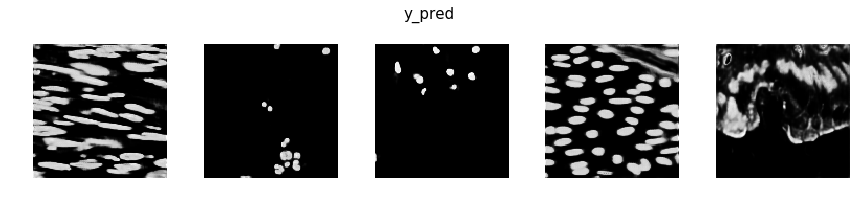

In [70]:
fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('x_test', fontsize=15)

axes = axes.flatten()

for img, ax in zip(X_test[:5], axes):
    ax.imshow(img)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(12,3))

fig.suptitle('y_pred', fontsize=15)

axes = axes.flatten()

for label, ax in zip(pred[:5], axes):
    ax.imshow(np.squeeze(label), cmap='gray')
    ax.axis('off')
    
plt.tight_layout()
plt.show()